In [65]:
import requests
import re
import time
from random import shuffle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def get_user_list(file, pause):
    '''
    Scrapes psnprofiles.com to get list of users on the site.

    Input:
    pause: int, number of seconds to pause between requests
    file: string, name of the file to write the list to

    Output:
    None
    '''
    users = set()
    while k < 58200:
        temp_response = requests.get('https://psnprofiles.com/leaderboard/all?page=' + str(k))
        temp_page = str(temp_response.content)
        temp_results = re.findall(r'href="/[\w]+"', temp_page)[9:]
        new_users = [x[7:-1] for x in temp_results]
        if len(new_users) > 0:
            users.update(new_users)
            k += 1
        else:
            print('No users found on page' + str(k) + '.')
            print(temp_page)
            k = 58200
        if k % 1000 == 0:
            with open(file, 'a') as f:
                for user in users:
                    f.write(user+'\n')
            users = set()
            print(str(k) + ' pages scraped. '+str(100*k/58209.)+'% done')
        time.sleep(pause)

In [5]:
def shuffle_users(user_list, shuffled_file):
    '''
    Takes a text file with a list of users and writes a shuffled list to a text file.
    
    Inputs:
    user_list: string, file with list of users
    shuffled_file: string, name for the output file
    
    Outputs:
    None
    '''
    users = []
    with open(user_list, 'r') as f:
        for line in f:
            users.append(line[:-1])
    shuffle(users)
    with open(shuffled_file, 'a') as file:
        for user in users:
            file.write(user + '\n')

In [6]:
def get_profiles(profiles_file, users_file, start_index, end_index, pause):
    '''
    Finds trophy information for users in the users_file list and writes this information
    to the profiles_file text file.
    
    Inputs:
    profiles_file: string, the text file to be written to
    users_file: string, list of users to read from
    start_index: int, first user in list to get information for
    end_index: int, last user
    pause: int, number of seconds to wait between requests    
    
    Outputs:
    None
    '''  
    users = []
    with open(users_file, 'r') as f:
        for line in f:
            users.append(line[:-1])
    with open(profiles_file, 'a') as f2:
        for k, user in enumerate(users[start_index:end_index]):
            responses = str(requests.get('https://psnprofiles.com/' + user).content).split('"game"')[1:]
            for entry in responses:
                game = re.search('alt="(.+?)"', entry).group(1)
                rank = re.search('game-rank ([A-Z])', entry).group(1)
                f2.write(user + '\t' + game + '\t' + rank + '\n')
            if k % 1000 == 0:
                print(k)
            time.sleep(delay)

In [1]:
rank_dict = {'S' : 6, 'A' : 5, 'B' : 4, 'C' : 3, 'D' : 2, 'F' : 1}

In [7]:
def df_from_tsv(file):
    '''
    Produces a Pandas DataFrame from the tab-separated text_file output by get_profiles.
    
    input
    file: string, the path of a text file where each line is of the form
    PSN ID \t Game name \t Trophy Rank
    
    output
    df: a DataFrame whose index is PSN id, columns are game names, and values are trophy ranks
    on a scale of -2 to 3.
    '''
    
    df = pd.read_csv(file, delimiter='\t', names = ['PSNid', 'Game', 'Rank'])
    df['Game'] = df['Game'].transform\
                        (lambda title: ''.join(char for char in title if ord(char)<128))
    df['Game'] = df['Game'].transform(lambda title: re.sub(r"\\", '', \
                        re.sub('u[\d]+', '', title)))
    df['Rank'] = df['Rank'].map(rank_dict)
    df = df.pivot_table(index = 'PSNid', columns = 'Game', aggfunc = max)['Rank']
    return df  

In [8]:
def build_sim_mat_file(df, output_file, first_sample, last_sample):
    '''
    Builds a similarity matrix from a df. This matrix is very large, and may be impractical
    to store in memory, so we write it to a file.
    Each line of the file will be of the form 'user1 \t user2 \t similarity'
    
    input:
    df: pandas DataFrame, where the index is users, the columns are games,
    and the values are trophy ranks.
    output_file: string, path to text file
    first_sample: int, first sample in df to check
    last_sample: int, last sample in df to check
    These last two are to allow building the file in shifts, or writing to multiple files.
    For each sample between first_sample and last_sample, the similarity score of that user
    with all *previous* users in the list (including those before first_sample)
    will be written to the file.
    
    output:
    None
    '''
    counter = 0
    total_pairs = sum(i for i in range(first_sample,last_sample))
    start_time = time.time()

    for i in range(first_sample, last_sample):
        for j in range(i):
            sim = compute_sim(df.iloc[i], df.iloc[j])
            with open(output_file, 'a') as file:
                file.write(users[i] + '\t' + users[j] + '\t' + str(sim) + '\n')
            counter += 1
            if counter % 5e4 == 50:
                completion = 100 * counter/float(total_pairs)
                elapsed = (time.time() - start_time)/3600.
                remaining = (100 - completion) * elapsed/completion
                print('{0:.2f}% done. {1:.2f} hours elapsed. Estimated time remaining: {2:.2f} hours.'.format\
                    (completion, elapsed, remaining))

In [9]:
def compute_sim(a,b):
    a = np.array(a.fillna(0))
    b = np.array(b.fillna(0))
    # Note we add a tiny positive number to the denominator to prevent division by zero
    # when one of the users has no ratings (or only ratings of 0).
    return(a.dot(b)/(np.linalg.norm(a) * np.linalg.norm(b) + 1e-5))

In [10]:
def find_game_recs(user, game_ranks_df, sim_files):
    '''
    Takes a user and a list of sim_files and produces game recommendations for that user.
    
    input:
    user: string, PSN id of user
    game_ranks_df: pandas DataFrame, where index is users, columns are games, values are ranks
    sim_files: list of strings, each one a path to a file containing similarity scores,
                in the format output by build_sim_mat_file
                
    output:
    game_recs: pandas Series, predicted trophy ranks for games user has not played, ranked
                highest to lowest
    ''' 
    num_users = game_ranks_df.shape[0]
    game_recs = pd.Series(0, index = game_ranks_df.columns.values)
    for file in sim_files:
        with open(file, 'r') as f:
            sim_list = [line.split('\t') for line in f if user in line.split('\t')]
        for triple in sim_list:
            if triple[0] == user:
                other_user = triple[1]
            else:
                other_user = triple[0]
            sim = triple[2]
            ranks = game_ranks_df.loc[other_user].fillna(0)
            game_recs = game_recs + (100*float(sim)/num_users) * ranks
            game_recs = game_recs[pd.isnull(game_ranks_df.loc[user])]
    return game_recs.sort_values(ascending = False)

In [11]:
def find_game_recs_centered(user, game_ranks_df, sim_files):
    '''
    Takes a user and a list of sim_files and produces game recommendations for that user.
    
    input:
    user: string, PSN id of user
    game_ranks_df: pandas DataFrame, where index is users, columns are games, values are ranks
    sim_files: list of strings, each one a path to a file containing similarity scores,
                in the format output by build_sim_mat_file
                
    output:
    game_recs: pandas Series, predicted trophy ranks for games user has not played, ranked
                highest to lowest
    ''' 
    num_users = game_ranks_df.shape[0]
    game_recs = pd.Series(0, index = game_ranks_df.columns.values)
    means = game_ranks_df.loc['mean_values']
    for file in sim_files:
        with open(file, 'r') as f:
            sim_list = [line.split('\t') for line in f if user in line.split('\t')]
        for triple in sim_list:
            if triple[0] == user:
                other_user = triple[1]
            else:
                other_user = triple[0]
            sim = triple[2]
            ranks = game_ranks_df.loc[other_user].fillna(means)
            game_recs = game_recs + (100*float(sim)/num_users) * (ranks - means)
            game_recs = game_recs[pd.isnull(game_ranks_df.loc[user])]
    return game_recs.sort_values(ascending = False)

In [12]:
df = df_from_tsv('psn_profiles2.txt')
df2 = df_from_tsv('psn_profiles3.txt')
df3 = df_from_tsv('psn_profiles5.txt')

In [17]:
df = df.append(df2).append(df3)
df = df[~df.index.duplicated(keep='first')]

In [24]:
df.sum().sort_values(ascending = False).iloc[0:10]

Grand Theft Auto V                     59036.0
Call of Duty: Black Ops                39617.0
Call of Duty: Black Ops II             35979.0
Call of Duty: Modern Warfare 2         35771.0
Call of Duty: Modern Warfare 3         34225.0
Destiny                                29220.0
LittleBigPlanet                        29028.0
Uncharted 3: Drake&#039;s Deception    28347.0
Call of Duty: Ghosts                   27579.0
Assassin&#039;s Creed II               27572.0
dtype: float64

In [36]:
'''
People who enjoyed the story-focused open-world RPG NieR: Automata also enjoyed RPGs like Persona 5 and 
Final Fantasy XV, open-world games like Metal Gear Solid V and Horizon Zero Dawn, 
and story-based games like Life is Strange.
'''

(df[df['NieR: Automata'] == 6].sum()/len(df[df['NieR: Automata'] == 6])
- (df/len(df)).sum()).sort_values(ascending = False).iloc[0:10]

NieR: Automata                          5.911046
Final Fantasy XV                        2.363486
Horizon Zero Dawn                       2.317029
Bloodborne                              2.239351
Dark Souls III                          1.860601
Uncharted 4: A Thief&#039;s End         1.729454
Persona 5                               1.593826
Life is Strange                         1.503396
Nioh                                    1.410986
Metal Gear Solid V: The Phantom Pain    1.336457
dtype: float64

In [35]:
'''
People who enjoyed the 2D indie game Rogue Legacy also liked other 2D indie games like 
Transistor, Teslagrad, The Binding of Isaac, Resogun, and Valiant Hearts.
'''

df[df['Rogue Legacy'] == 6].sum().sort_values(ascending = False).iloc[:10]

Rogue Legacy                     396.0
Bloodborne                       165.0
Transistor                       137.0
Rocket League                    132.0
inFamous First Light             130.0
inFamous Second Son              129.0
Teslagrad                        121.0
The Binding of Isaac: Rebirth    110.0
Resogun                          109.0
Valiant Hearts: The Great War    109.0
dtype: float64

In [39]:
df = df.fillna(0)

In [54]:
m = df.shape[0]
ranks = np.array(range(7))

from matplotlib import pyplot as plt

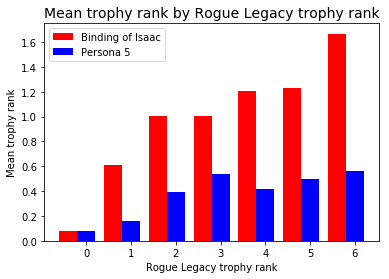

In [72]:
'''
This graph shows that Rogue Legacy trophy rank is far more predictive of Binding of Isaac trophy rank
than it is of Persona 5 trophy rank. Rogue Legacy and Binding of Isaac are both 2D indie rogue-likes,
while Persona 5 is a story-focused role-playing game.

(Note that these averages include people who do not own the game in question, which is why they are all quite low.
To a large extent, what it is predicting is whether the user owns the other game.)
'''

means = [df[df['Rogue Legacy'] == k]['The Binding of Isaac: Rebirth'].mean() for k in range(7)]
means2 = [df[df['Rogue Legacy'] == k]['Persona 5'].mean() for k in range(7)]

ax = plt.subplot(111)
ax.bar(ranks - 0.4, means, width = 0.4, color = 'r', label = 'Binding of Isaac')
ax.bar(ranks, means2, width = 0.4, color = 'b', label = 'Persona 5')
ax.legend(loc = 'upper left', fontsize = 10)
plt.xlabel('Rogue Legacy trophy rank', fontsize = 10)
plt.ylabel('Mean trophy rank', fontsize = 10)
plt.title('Mean trophy rank by Rogue Legacy trophy rank', fontsize = 14)

plt.show()

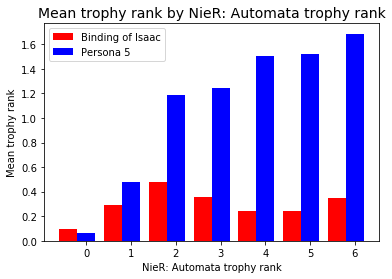

In [74]:
'''
In contrast, NieR: Automata is far more predictive of Persona 5 trophy rank than of Binding of Issac trophy rank.
Like Person 5, NieR: Automata is a story-focused Japanese role-playing game.
'''

means3 = [df[df['NieR: Automata'] == k]['The Binding of Isaac: Rebirth'].mean() for k in range(7)]
means4 = [df[df['NieR: Automata'] == k]['Persona 5'].mean() for k in range(7)]

ax2 = plt.subplot(111)
ax2.bar(ranks - 0.4, means3, width = 0.4, color = 'r', label = 'Binding of Isaac')
ax2.bar(ranks, means4, width = 0.4, color = 'b', label = 'Persona 5')
ax2.legend(loc = 'upper left', fontsize = 10)
plt.xlabel('NieR: Automata trophy rank', fontsize = 10)
plt.ylabel('Mean trophy rank', fontsize = 10)
plt.title('Mean trophy rank by NieR: Automata trophy rank', fontsize = 14)

plt.show()